### Stacking이란?

앙상블의 모델 종류 중 하나로, 개별적인 모델이 학습하고 예측한 데이터를 쌓아서 또 다른 학습데이터로 만들고 이 데이터를 기반으로 메타 모델을 하나 더 만들어 예측하는 모델

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [8]:
# 개별 모델 정의
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier()
ab_clf = AdaBoostClassifier()
dt_clf = DecisionTreeClassifier()
# 최종 메타 모델 정의
lr_final = LogisticRegression(C=10)

In [19]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings(action='ignore')

# 개별모델 내부에서 CV 적용해 Stacking하는 함수 구현
def get_stacking_datasets(model, x_train_n, y_train_n, x_test_n, n_folds):
    # CV하기 위해 K-fold 설정
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((x_train_n.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((x_test_n.shape[0], n_folds))
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(kf.split(x_train_n)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        x_tr = x_train_n[train_idx]
        y_tr = y_train_n[train_idx]
        x_te = x_train_n[valid_idx]
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(x_tr, y_tr)
        train_fold_pred[valid_idx, :] = model.predict(x_te).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(x_test_n)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

knn_train, knn_test = get_stacking_datasets(knn_clf, x_train, y_train, x_test, 5)
rf_train, rf_test = get_stacking_datasets(rf_clf, x_train, y_train, x_test, 5)
ab_train, ab_test = get_stacking_datasets(ab_clf, x_train, y_train, x_test, 5)
dt_train, dt_test = get_stacking_datasets(dt_clf, x_train, y_train, x_test, 5)

KNeighborsClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
RandomForestClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
AdaBoostClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
DecisionTreeClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5


In [22]:
# 개별모델이 생성한 학습/검증 데이터 최종 메타 모델이 학습/검증하도록 결합
stack_final_x_train = np.concatenate((knn_train, rf_train, ab_train, dt_train), axis=1)
stack_final_x_test = np.concatenate((knn_test, rf_test, ab_test, dt_test), axis=1)

# 최종 메타모델로 학습
# 최종 메타모델 학습시 label은 원본 데이터의 label(y값)
lr_final.fit(stack_final_x_train, y_train)
stack_final_pred = lr_final.predict(stack_final_x_test)

# 최종 메타모델 성능 평가(비교할 때 원본 데이터의 검증 데이터 label과 비교)
print(f"최종 메타모델 정확도 : {accuracy_score(y_test, stack_final_pred):.4f}")

최종 메타모델 정확도 : 0.9474


### 3.4.4 Ensemble Methods

In [14]:
import numpy as np

N = 1500

mean1 = [6, 14]
mean2 = [10, 6]
mean3 = [14, 14]
cov = [[3.5, 0],[0, 3.5]]

np.random.seed(50)
X = np.random.multivariate_normal(mean1,cov,int(N/6))
X = np.concatenate((X,np.random.multivariate_normal(mean2,cov,int(N/6))))
X = np.concatenate((X,np.random.multivariate_normal(mean3,cov,int(N/6))))
X = np.concatenate((X,20*np.random.rand(int(N/2),2)))
Y = np.concatenate((np.ones(int(N/2)),np.zeros(int(N/2))))

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.8, random_state=1)


[Text(1.5, 0, 'Random Forest'),
 Text(2.5, 0, 'Bagging'),
 Text(3.5, 0, 'AdaBoost')]

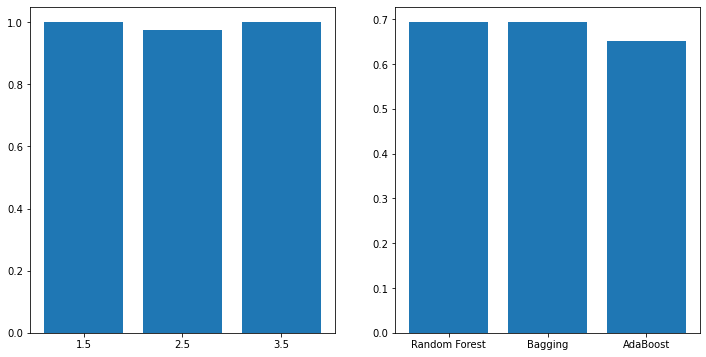

In [15]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

numBaseClassifiers = 500
maxdepth = 10
trainAcc = []
testAcc=[]

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
clf.fit(X_train,Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test,Y_predTest))

clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train,Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test,Y_predTest))

clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train,Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test,Y_predTest))

methods = ['Random Forest','Bagging','AdaBoost']
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.bar([1.5,2.5,3.5],trainAcc)
ax1.set_xticks([1.5,2.5,3.5])
ax2.bar([1.5,2.5,3.5],testAcc)
ax2.set_xticks([1.5,2.5,3.5])
ax2.set_xticklabels(methods)